In [1]:
# !pip install -r ../requirements.txt

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/preprocessed_data_points.csv')
df.head(2)

,_id,image_url,brands,is_beverage,pnns_groups_2,energy-kj_100g,sugars_100g,salt_100g,saturated-fat_100g,proteins_100g,...,negative_points,positive_points,energy_points,sugars_points,sodium_points,saturated_fat_points,fruit_points,fiber_points,proteins_points,our_total_points
0,4.000522e+12,https://images.openfoodfacts.org/images/produc...,"Pombär, Intersnack Deutschland SE",N,Appetizers,2142.0,1.3,1.5,2.5,3.0,...,10.0,5.0,6,0,6,2,0,1,1,12
1,4.003586e+12,https://images.openfoodfacts.org/images/produc...,funny-frisch Diverse,N,Appetizers,2209.0,2.5,1.6,3.0,6.1,...,9.0,10.0,6,0,7,2,0,4,3,8


In [4]:
# Getting the columns
df.columns, df.shape

(Index(['_id', 'image_url', 'brands', 'is_beverage', 'pnns_groups_2',
        'energy-kj_100g', 'sugars_100g', 'salt_100g', 'saturated-fat_100g',
        'proteins_100g', 'fiber_100g',
        'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'sodium_100g',
        'nutrition-score-fr_100g', 'nutrition_grade_fr', 'negative_points',
        'positive_points', 'energy_points', 'sugars_points', 'sodium_points',
        'saturated_fat_points', 'fruit_points', 'fiber_points',
        'proteins_points', 'our_total_points'],
       dtype='object'),
 (124, 25))

In [5]:
columns_of_interest = ['sugars_100g', 'salt_100g', 'saturated-fat_100g','proteins_100g', 'fiber_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'sodium_100g']
df1 = df[columns_of_interest]
y = df['nutrition-score-fr_100g']
df1.head(2)

,sugars_100g,salt_100g,saturated-fat_100g,proteins_100g,fiber_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,sodium_100g
0,1.3,1.5,2.5,3.0,1.6,0.0,0.60
1,2.5,1.6,3.0,6.1,4.2,0.0,0.64


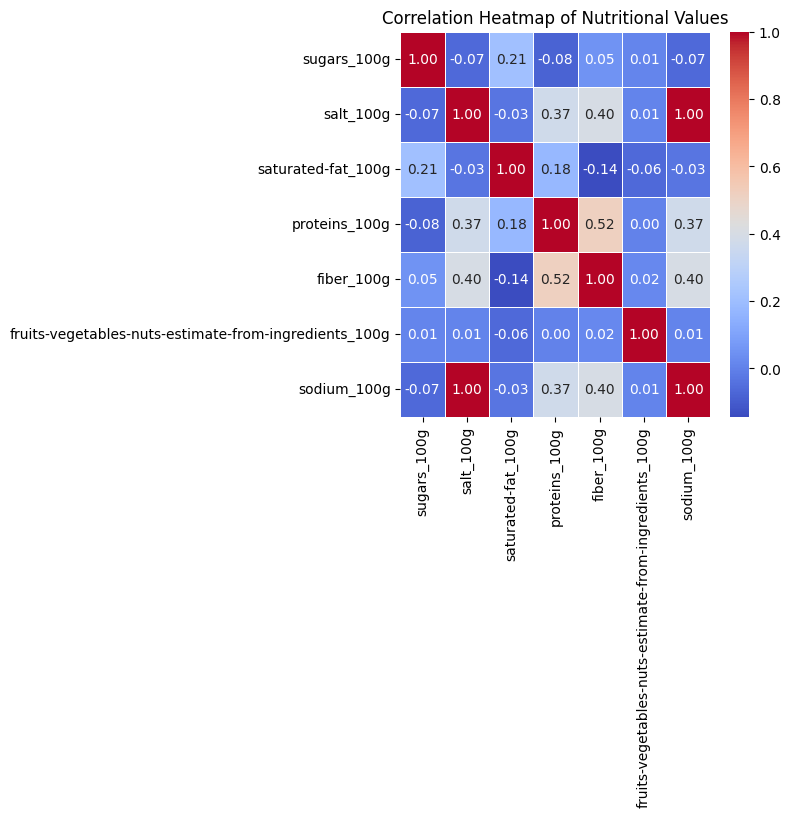

In [6]:
correlation_matrix = df1.corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Nutritional Values')
plt.show()

In [7]:
def get_top_correlations_blog(df, threshold=0.4):
    """
    df: the dataframe to get correlations from
    threshold: the maximum and minimum value to include for correlations. 
    For eg, if this is 0.4, only pairs haveing a correlation coefficient greater than 0.4 
    or less than -0.4 will be included in the results. 
    """
    orig_corr = df.corr()
    c = orig_corr.abs()

    so = c.unstack()
    
    i=0
    pairs=set()
    result = pd.DataFrame()
    for index, value in so.sort_values(ascending=False).iteritems():
        # Exclude duplicates and self-correlations
        if value > threshold \
        and index[0] != index[1] \
        and (index[0], index[1]) not in pairs \
        and (index[1], index[0]) not in pairs:
            
            # print(f'|    {index[0]}    |    {index[1]}    |    {orig_corr.loc[(index[0], index[1])]}    |')
            result.loc[i, ['Variable 1', 'Variable 2', 'Correlation']] = [index[0], index[1], orig_corr.loc[(index[0], index[1])]]
            pairs.add((index[0], index[1]))
            i+=1
    return result.reset_index(drop=True).set_index(['Variable 1', 'Variable 2'])

In [8]:
top_corr = get_top_correlations_blog(df1)
top_corr

Correlation
Variable 1    Variable 2              
sodium_100g   salt_100g       1.000000
proteins_100g fiber_100g      0.516953
fiber_100g    sodium_100g     0.401435
              salt_100g       0.401435

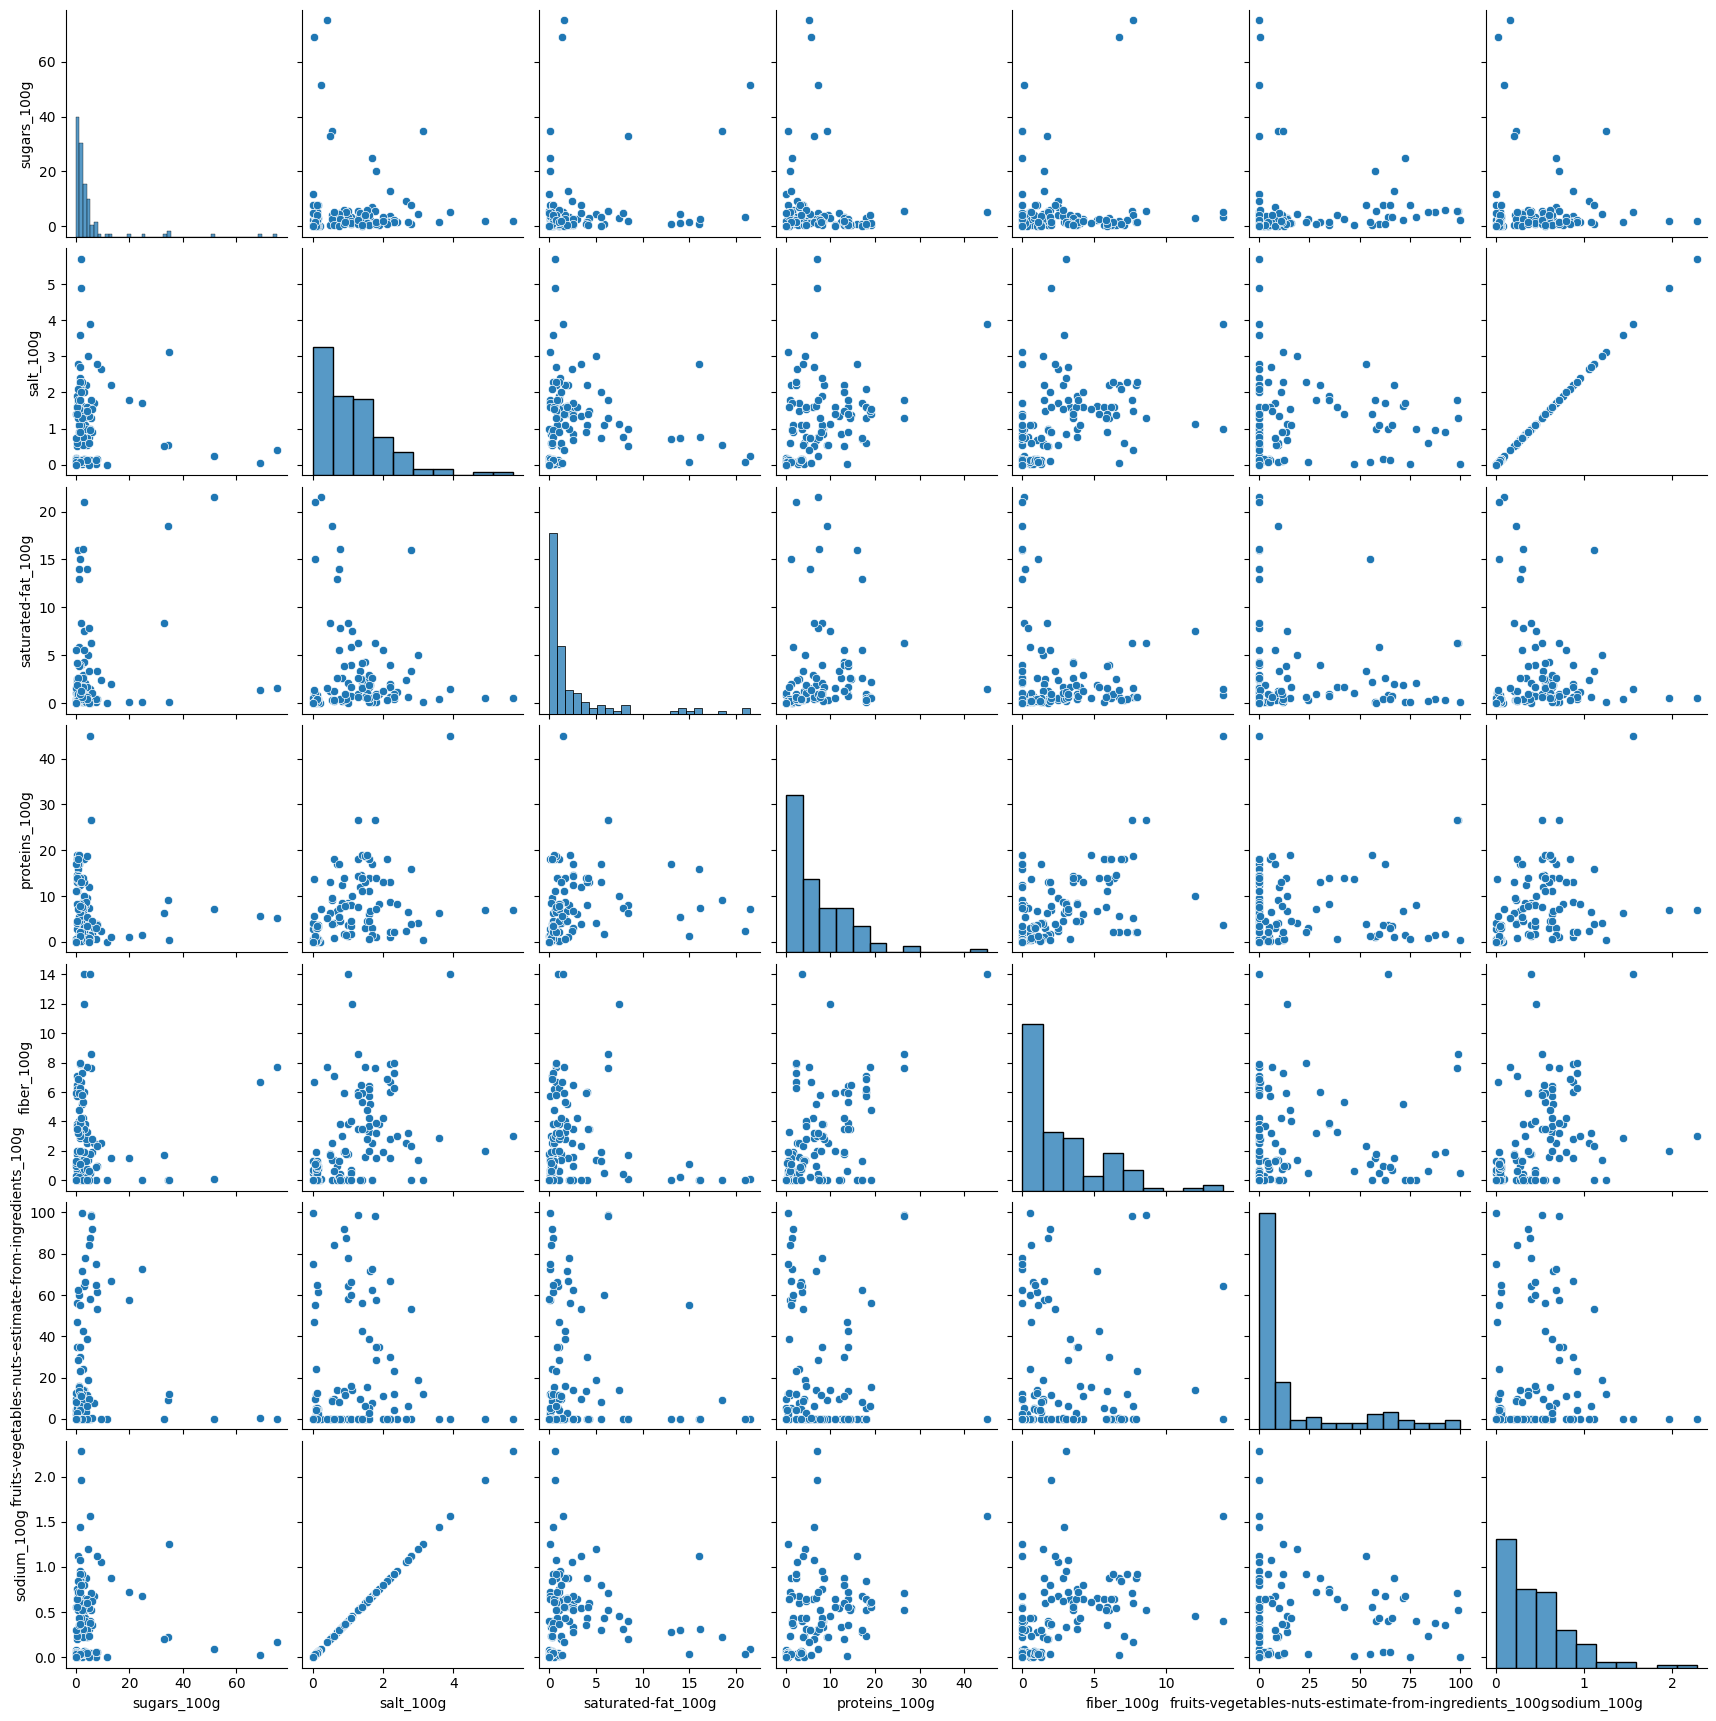

<Figure size 1000x800 with 0 Axes>

In [9]:
# view the distribution and correlation of those strong features by each class

sns.pairplot(df1)
plt.figure(figsize = (10,8))
plt.show()

Some observations:
* Either salt or sodium can be omitted (as it is fully correlated (100%))
* Energy and fats are half correlated (50%)
* Fibers and proteins are half correlated (50%)
* Energy and proteins are half correlated (46%)

Our decisions:
* Ignore salt and include sodium
* Ignore energy (due to correlation with proteins and fats)
* Maximise 1/2(fibers+proteins) as they are correlated
* Assign weight of fruits-vegetables-nuts as 1, as it has weak correlations with all the other variables